In [1]:
%reset -f

In [ ]:
# !pip install torchdiffeq
# !pip install numpy
# !pip install matplotlib
# !pip install torch 

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from typing import List

In [4]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# --- build a simple rod: 3 DOF per node (x,y,z) ---
def create_rod_with_nodes(num_nodes: int):
    nodes = []
    for i in range(num_nodes):
        nodes.append(np.array([i * 0.1, 0.0, 0.0], dtype=np.float32))
    return nodes
num_nodes = 11
nodes = create_rod_with_nodes(num_nodes)  # 11 nodes -> ndof = 33
q0 = np.array(nodes, dtype=np.float32).reshape(-1)         # positions (ndof,)
# include edge dofs
q0 = np.concatenate([q0, np.zeros(num_nodes - 1, dtype=np.float32)])  # (ndof + nedges,)
v0 = np.zeros_like(q0, dtype=np.float32)                   # velocities (ndof,)
# omega = 0.1
# for i in range(2, num_nodes):
#     v0[3*i + 2] = omega*(q0[3*i]-0.1) # z-velocities

x0 = torch.tensor(np.concatenate([q0, v0]), dtype=torch.float32)  # (2*ndof,)

# print("Initial positions q0:", q0)
# print("Initial velocities v0:", v0)
# print("Initial state x0:", x0)

# create springs (3 consecutive nodes and effective length)
stretch_springs = []
bend_twist_springs = []
d1_init = []   
d2_init = [] 
edges = []
l0_edges = []

for j in range(0, num_nodes - 1):
    edges.append((j, j + 1))
    l0 = np.linalg.norm(np.array(nodes[j+1] - nodes[j]))
    l0_edges.append(l0)
    d1_init.append((0.0, 1.0, 0.0))  # initial ref frame d1 (edge0, edge1)
    d2 = np.cross(np.array(nodes[j+1] - nodes[j]), np.array([0.0, 1.0, 0.0]))
    d2_init.append(d2)  # initial ref frame d2 (edge0, edge1)

for i in range(0, num_nodes):
    if i == 0:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        stretch_springs.append((i, i + 1, None, l0, None))
    elif i == num_nodes - 1:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        stretch_springs.append((i - 1, i, None, l0, None))
    else:
        # internal nodes: leff = 0.1
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        l1 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        leff = 0.5 * (l0 + l1)
        stretch_springs.append((i - 1, i, i + 1, l0, l1))
        bend_twist_springs.append((i - 1, i, i + 1, i-1, i)) # xi,xj,xk, theta_prev, theta_next


# Material properties
E = 1e7  # Young's modulus
r0 = 0.01  # radius
A = np.pi * r0**2  # cross-sectional area
I = 0.25 * np.pi * r0**4  # area moment of inertia
J = 2 * I  # polar moment of inertia
rho = 1200  # density
mass = rho*A*1  # mass per segment (length 1 m)
m_per_node = mass/num_nodes

EA = E * A  # axial stiffness
EI = E * I  # bending stiffness
GJ = (E/(2*(1+0.5))) * J  # torsional stiffness (assuming Poisson's ratio = 0.5)
stiffnesses = torch.tensor([EA, EI, EI, GJ], dtype=torch.float32)  # example stiffnesses for 4 strain components

# print("Stretch springs:", stretch_springs)
# print("Bend springs:", bend_twist_springs)
print(f"EA={EA:.3e}, EI={EI:.3e}, GJ={GJ:.3e}")


EA=3.142e+03, EI=7.854e-02, GJ=5.236e-02


In [6]:
# read ref trajectory from file
x_ref = torch.load('analytical_beam_trajectory.pt') # (T, 2*ndof)

In [7]:
# from strains_torch import get_strain_stretch2D_torch, get_strain_curvature_3D_torch
from new_3D_strains import rod_strains_vectorized, rod_strains_from_local_qs

In [8]:
class neuralODE(nn.Module):
    def __init__(self, edges: torch.Tensor, l0_edges: List[float], n_nodes: int, ndof: int, m_per_dof: float = 1.0, c_per_dof: float = 0.1, \
                 g: float = 9.81, freeDOF: List[int]=None, \
                    energy_nn: nn.Module = None, bend_twist_springs: torch.Tensor = None, \
                    d1_init: torch.Tensor = None, d2_init: torch.Tensor = None, dtype=torch.float32):
        super().__init__()
        self.ndof = ndof
        self.n_nodes = n_nodes
        self.freeDOF = freeDOF
        self.call_count = 0
        # Neural elastic energy
        assert energy_nn is not None, "Pass an EnergyNN instance"
        self.energy_model = energy_nn

        # edges, directors 
        self.register_buffer("edges", edges)  # (E,2)
        self.register_buffer("l0_edges", torch.tensor(l0_edges, dtype=dtype))  # (E,)
        self.n_edges = edges.shape[0]
        self.register_buffer("d1_init", d1_init)  # (E,3)
        self.register_buffer("d2_init", d2_init)  # (E,3
        
        # Indices / masks
        if freeDOF is None:
            freeDOF = list(range(ndof))
        free_idx = torch.as_tensor(freeDOF, dtype=torch.long)
        fixed_mask = torch.ones(ndof, dtype=torch.bool)
        fixed_mask[free_idx] = False
        self.register_buffer("free_idx", free_idx)
        self.register_buffer("fixed_mask", fixed_mask)
        self.register_buffer("free_mask", ~fixed_mask)  # same shape

        # Diagonal mass and damping for now (easy to replace with full matrices later)
        M = torch.eye(ndof) * m_per_dof       # (ndof, ndof)
        C = torch.eye(ndof) * c_per_dof       # (ndof, ndof)

        # Gravity as external force: acts in z only (every 3rd DOF starting from index 2)
        f_ext = torch.zeros(ndof)
        f_ext[2::3] = -m_per_dof * g          # (ndof,)

        # Register as buffers so dtype/device track the module (and no grads)
        self.register_buffer("M", M)
        self.register_buffer("C", C)
        self.register_buffer("f_ext", f_ext)

        # Pre-slice free blocks once (for diagonal M this is overkill but scales)
        self.register_buffer("M_ff", M.index_select(0, free_idx).index_select(1, free_idx))
        self.register_buffer("C_ff", C.index_select(0, free_idx).index_select(1, free_idx))

        # stencils
        self.register_buffer("bend_twist_springs", bend_twist_springs)

            # ----------------------------------------------------------
            # Vectorized elastic force using bend_twist_springs
            # Local order: [xi,xj,xk, theta_prev, theta_next]
            # Global order: [all nodes xyz..., all edge thetas...]
            # ----------------------------------------------------------

    def elastic_force(self, q: torch.Tensor, eps=1e-12) -> torch.Tensor:
        device = q.device
        batch_shape = q.shape[:-1]
        ndof = q.shape[-1]

        N = self.n_nodes
        nodal_ndof = 3 * N
        theta_offset = nodal_ndof

        # infer E from q (robust)
        E = ndof - nodal_ndof
        if E <= 0:
            raise RuntimeError(f"Need edge DOFs in q. Got ndof={ndof}, 3*n_nodes={nodal_ndof} => E={E}")

        springs_all = self.bend_twist_springs.to(device).long()  # (S,5) (i,j,k,e_prev,e_next)
        edges = self.edges.to(device).long()

        # filter springs if q has fewer edge dofs than mesh expects (debug-friendly)
        e_prev_all = springs_all[:, 3]
        e_next_all = springs_all[:, 4]
        mask = (e_prev_all < E) & (e_next_all < E)
        springs = springs_all[mask]
        S = springs.shape[0]
        if S == 0:
            return torch.zeros_like(q)

        # flatten batch
        Btot = int(torch.tensor(batch_shape).prod().item()) if len(batch_shape) else 1
        q_flat = q.reshape(Btot, ndof)

        # split
        x = q_flat[:, :nodal_ndof].reshape(Btot, N, 3)     # (B,N,3)
        theta = q_flat[:, theta_offset:].reshape(Btot, E)  # (B,E)

        # spring indices
        i = springs[:, 0]; j = springs[:, 1]; k = springs[:, 2]
        e_prev = springs[:, 3]; e_next = springs[:, 4]

        # gather nodal coords
        x_i = x[:, i, :]
        x_j = x[:, j, :]
        x_k = x[:, k, :]

        # gather thetas
        th_prev = theta[:, e_prev]
        th_next = theta[:, e_next]

        # local dof vector (B,S,11) and make it the differentiation input
        q_s = torch.cat([x_i, x_j, x_k, th_prev[..., None], th_next[..., None]], dim=-1)
        # q_s = q_s.clone().requires_grad_(True)
        q_s.requires_grad_(True)


        # gather per-edge rest lengths for the two incident edges
        l0 = torch.as_tensor(self.l0_edges, device=device, dtype=q.dtype)
        if l0.dim() == 0:
            l0 = l0.expand(E)
        l0_prev = l0[e_prev].view(1, S).expand(Btot, S)
        l0_next = l0[e_next].view(1, S).expand(Btot, S)

        # gather reference directors for the two incident edges
        d1_all = torch.as_tensor(self.d1_init, device=device, dtype=q.dtype)  # (E,3)
        d2_all = torch.as_tensor(self.d2_init, device=device, dtype=q.dtype)  # (E,3)
        d1_prev = d1_all[e_prev].view(1, S, 3).expand(Btot, S, 3)
        d2_prev = d2_all[e_prev].view(1, S, 3).expand(Btot, S, 3)
        d1_next = d1_all[e_next].view(1, S, 3).expand(Btot, S, 3)
        d2_next = d2_all[e_next].view(1, S, 3).expand(Btot, S, 3)

        # strains computed FROM q_s => graph is connected
        strains = rod_strains_from_local_qs(
            q_s, l0_prev, l0_next,
            d1_prev, d2_prev, d1_next, d2_next,
            eps=eps
        )  # (B,S,4)

        # energy + grad wrt q_s
        E_s = self.energy_model(strains)  # (B,S,1) or (B,S)
        (dE_dqs,) = torch.autograd.grad(E_s.sum(), q_s, create_graph=True)
        f_s = -dE_dqs  # (B,S,11)

        # scatter-add into global force
        f_full = torch.zeros_like(q_flat)

        def xyz_idx(node_ids):
            base = (3 * node_ids).unsqueeze(-1)  # (S,1)
            off = torch.tensor([0, 1, 2], device=device, dtype=torch.long)
            return base + off

        idx_x_i = xyz_idx(i)
        idx_x_j = xyz_idx(j)
        idx_x_k = xyz_idx(k)
        idx_th_prev = (theta_offset + e_prev).unsqueeze(-1)
        idx_th_next = (theta_offset + e_next).unsqueeze(-1)

        idx11 = torch.cat([idx_x_i, idx_x_j, idx_x_k, idx_th_prev, idx_th_next], dim=-1)  # (S,11)

        idx_flat = idx11.reshape(1, S * 11).expand(Btot, S * 11)
        src_flat = f_s.reshape(Btot, S * 11)
        f_full.scatter_add_(dim=1, index=idx_flat, src=src_flat)

        return f_full.reshape(*batch_shape, ndof)

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        x shape: (..., 2*ndof)
        Returns dx/dt with same shape.
        """
        ndof = self.ndof
        q = x[..., :ndof]        # (..., ndof)
        v = x[..., ndof:]        # (..., ndof)

        # Forces
        f_el = self.elastic_force(q)          # (..., ndof)
        # test = torch.autograd.grad(f_el.sum(), q, allow_unused=True)[0]
        # print("df/dq is None?", test is None, "mean abs:", None if test is None else test.abs().mean().item())
        f_damp = torch.matmul(v, self.C.T)    # (..., ndof)

        # External + elastic + damping
        rhs = -f_damp + f_el + self.f_ext     # (..., ndof)

        # Free-DOF solve
        idx = self.free_idx
        rhs_f = rhs.index_select(-1, idx)     # (..., n_free)
        v_f   = v.index_select(-1, idx)       # (..., n_free)

        M_ff = self.M_ff
        a_f = torch.linalg.solve(M_ff, rhs_f.unsqueeze(-1)).squeeze(-1)  # (..., n_free)

        # Scatter back to full
        a_full = torch.zeros_like(v)
        v_full = torch.zeros_like(v)
        a_full[..., idx] = a_f
        v_full[..., idx] = v_f

        dxdt = torch.cat([v_full, a_full], dim=-1)

        # Logging
        self.call_count += 1
        if self.call_count % 1000 == 0:
            ke = 0.5 * torch.sum(v_full**2)
            print(f"[{self.call_count}] t={t.item():.3f}, KE={ke.item():.3e}")

        return dxdt


In [9]:
from EnergyNN import EnergyNN, LinearElasticEnergyNN, LinearEnergyLayer

In [10]:
# --- set up and integrate ---
ndof = q0.size
freeDOF = list(range(6, ndof))  # fix first two nodes (first 6 DOF)

# guess_stiffnesses = stiffnesses + np.random.randn(4) * 1e-3
guess_stiffnesses = stiffnesses
energy_nn = LinearEnergyLayer(n_strain=4, dtype=torch.float32, weights = guess_stiffnesses)
# energy_nn = LinearEnergyLayer(n_strain=4, dtype=torch.float32)
# used values of stiffnesses:
W = energy_nn.stiffness().detach()
print(W)

odefunc = neuralODE(edges = torch.tensor(edges, dtype=torch.int64), l0_edges=l0_edges, n_nodes = num_nodes , ndof=ndof,
                  m_per_dof=m_per_node,
                  c_per_dof=0.1,
                  g=9.81,
                  freeDOF=freeDOF,
                  energy_nn=energy_nn,
                  bend_twist_springs=torch.tensor(bend_twist_springs, dtype=torch.int64), 
                  d1_init=torch.tensor(d1_init, dtype=torch.float32),
                  d2_init=torch.tensor(d2_init, dtype=torch.float32),
                  dtype=torch.float32).to(device)

optimizer = optim.Adam(odefunc.energy_model.parameters(), lr=1e-3)


tensor([3.1416e+03, 7.8540e-02, 7.8540e-02, 5.2360e-02])


/var/folders/z0/3frv2l990hb5ryd49z8vm4w80000gn/T/ipykernel_2110/4218521028.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  d2_init=torch.tensor(d2_init, dtype=torch.float32),


In [11]:
def batched_segment_loss(
    student,
    x_ref,           # (steps_total, 2*ndof)
    dt: float,
    seg_T: float,
    batch_size: int,
    weight_q: float = 1.0,
    weight_v: float = 1.0,
    method: str = 'dopri5',
    options: dict = {'max_num_steps': 10000}
):
    device = x_ref.device
    dtype  = x_ref.dtype

    total_steps, state_dim = x_ref.shape
    ndof = state_dim // 2
    seg_steps = int(seg_T / dt) + 1

    max_start = total_steps - seg_steps
    assert max_start >= 0, "trajectory too short for this seg_T"

    # sample random segment starts: shape (B,)
    start_idx = torch.randint(0, max_start + 1, (batch_size,), device=device)

    # build index matrix for each segment in the batch
    # shape (B, seg_steps): [i, :] = [start_i, start_i+1, ..., start_i+seg_steps-1]
    offsets = torch.arange(seg_steps, device=device)
    idx_mat = start_idx.unsqueeze(1) + offsets.unsqueeze(0)   # (B, seg_steps)

    # initial conditions: ref at each start time, shape (B, state_dim)
    x0_batch = x_ref[start_idx]   # (B, 2*ndof)

    # reference over segments: (B, seg_steps, state_dim)
    x_ref_batch = x_ref[idx_mat]  # (B, seg_steps, 2*ndof)
    # odeint returns (seg_steps, B, state_dim), so transpose to that layout
    x_ref_batch = x_ref_batch.transpose(0, 1)  # (seg_steps, B, 2*ndof)

    # time vector shared by all segments (relative time, ODE is autonomous)
    t_seg = torch.linspace(0., seg_T, seg_steps, device=device, dtype=dtype)

    # integrate with batched initial condition
    x_pred_batch = odeint(
        student,
        x0_batch,    # (B, 2*ndof)
        t_seg,       # (seg_steps,)
        method=method,
        rtol=1e-3,
        atol=1e-3,
        options=options
    )  # (seg_steps, B, 2*ndof)

    q_pred = x_pred_batch[..., :ndof]      # (seg_steps, B, ndof)
    v_pred = x_pred_batch[..., ndof:]      # (seg_steps, B, ndof)
    q_ref  = x_ref_batch[..., :ndof]       # (seg_steps, B, ndof)
    v_ref  = x_ref_batch[..., ndof:]       # (seg_steps, B, ndof)

    loss_q = torch.mean((q_pred - q_ref)**2)
    loss_v = torch.mean((v_pred - v_ref)**2)
    return weight_q * loss_q + weight_v * loss_v


In [12]:
def trajectory_loss(student, x0, t_eval, x_ref_traj,
                    weight_q=1.0, weight_v=1.0
                    ):
    """
    x0: (2*ndof,)
    t_eval: (T,)
    x_ref_traj: (T, 2*ndof)
    """

    # x_pred = odeint(
    #     student, x0, t_eval,
    #     method='dopri5',
    #     rtol=1e-3,
    #     atol=1e-3,
    #     options={'max_num_steps': 10000}
    # )  # (T, 2*ndof)

    x_pred = odeint(
        student, x0, t_eval,
        method='rk4',
        options={"step_size": float(t_eval[1]-t_eval[0])}
    )  # (T, 2*ndof)

    ndof = x0.numel() // 2

    q_pred = x_pred[..., :ndof]
    v_pred = x_pred[..., ndof:]
    q_ref  = x_ref_traj[..., :ndof]
    v_ref  = x_ref_traj[..., ndof:]

    loss_q = torch.mean((q_pred - q_ref)**2)
    loss_v = torch.mean((v_pred - v_ref)**2)
    return weight_q * loss_q + weight_v * loss_v



In [13]:
dtype=torch.float32


n_epochs = 5
T = 0.6
dt = 0.0001
steps = int(T/dt) + 1
t = torch.linspace(0., T, steps, dtype=dtype)

# Now move all inputs / reference data
x0    = x0.to(device=device, dtype=dtype)
t     = t.to(device=device, dtype=dtype)
# x_ref = x_ref.to(device=device, dtype=dtype)
# use only the part of x_ref that corresponds to t
x_ref = x_ref[:steps].to(device=device, dtype=dtype)

print("model param device:", next(odefunc.parameters()).device)
print("x0 device:", x0.device)
print("t device:", t.device)
print("x_ref device:", x_ref.device)


model param device: cpu
x0 device: cpu
t device: cpu
x_ref device: cpu


### Train the NN

In [14]:
# losses = []

# for epoch in range(1, n_epochs + 1):
#     optimizer.zero_grad()
#     loss = trajectory_loss(odefunc, x0, t, x_ref, weight_q=1.0, weight_v=1.0)
#     loss.backward()
#     optimizer.step()

#     losses.append(loss.item())

#     if epoch % 10 == 0:  # adjust frequency
#         k = odefunc.energy_model.stiffness().detach().cpu().numpy()
#         print("stiffness =", k)
#         print(f"Epoch {epoch:4d} | loss={loss.item():.3e}")


# # --- training loop with batched segments ---
# seg_T = 0.1
# batch_size = 8  # number of segments per batch
# losses = []
# for epoch in range(1, n_epochs + 1):
#     optimizer.zero_grad()
#     loss = batched_segment_loss(
#         odefunc,
#         x_ref,
#         dt=dt,
#         seg_T=seg_T,
#         batch_size=batch_size,
#         weight_q=1.0,
#         weight_v=1.0,
#         method='rk4',
#         options={'step_size': dt}
#     )
#     loss.backward()
#     optimizer.step()

#     losses.append(loss.item())

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, loss = {loss.item():.6e}")



# # --- Improved Training Loop ---
# n_epochs = 500
# batch_size = 16
# window_size = 5  # Number of time steps to look ahead

# for epoch in range(1, n_epochs + 1):
#     optimizer.zero_grad()
    
#     # Randomly sample start indices from the reference trajectory
#     # x_ref shape: (T, 2*ndof)
#     T = x_ref.shape[0]
#     start_indices = torch.randint(0, T - window_size, (batch_size,))
    
#     total_loss = 0
#     for idx in start_indices:
#         t_segment = t[idx : idx + window_size]
#         x0_batch = x_ref[idx] # Ground truth start for this window
        
#         # Predict only a short burst
#         x_pred = odeint(
#             odefunc, x0_batch, t_segment,
#             method='rk4',
#             options={"step_size": float(t[1]-t[0])}
#         )
        
#         x_target = x_ref[idx : idx + window_size]
#         total_loss += torch.mean((x_pred - x_target)**2)
    
#     loss = total_loss / batch_size
#     loss.backward()
    
#     # Critical: Clip gradients to prevent "NaN" if the solver takes a bad step
#     torch.nn.utils.clip_grad_norm_(odefunc.parameters(), max_norm=1.0)
    
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.6e}, K: {odefunc.energy_model.stiffness.detach().cpu().numpy()}")

In [15]:
# initial state x0: concat(q0, v0)  shape (2*ndof,)
dt_for_sim = 0.0001
steps = int(T/dt_for_sim) + 1
t = torch.linspace(0., T, steps, dtype=torch.float32)
traj = odeint(odefunc, x0, t, method='rk4')   # (steps, 2*ndof)

[1000] t=0.025, KE=3.333e-01
[2000] t=0.050, KE=1.220e+00
[3000] t=0.075, KE=2.513e+00
[4000] t=0.100, KE=4.094e+00
[5000] t=0.125, KE=5.864e+00
[6000] t=0.150, KE=7.741e+00
[7000] t=0.175, KE=9.655e+00
[8000] t=0.200, KE=1.155e+01
[9000] t=0.225, KE=1.338e+01
[10000] t=0.250, KE=1.510e+01
[11000] t=0.275, KE=1.669e+01
[12000] t=0.300, KE=1.813e+01
[13000] t=0.325, KE=1.938e+01
[14000] t=0.350, KE=2.042e+01
[15000] t=0.375, KE=2.127e+01
[16000] t=0.400, KE=2.199e+01
[17000] t=0.425, KE=2.255e+01
[18000] t=0.450, KE=2.290e+01
[19000] t=0.475, KE=2.298e+01
[20000] t=0.500, KE=2.277e+01
[21000] t=0.525, KE=2.232e+01
[22000] t=0.550, KE=2.168e+01
[23000] t=0.575, KE=2.099e+01


In [16]:
print("Solution shape:", traj.shape)           # (T, 2*ndof)
q_traj = traj[:, :ndof]                        # (T, ndof)
v_traj = traj[:, ndof:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])


Solution shape: torch.Size([6000, 86])
q_traj[0]: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000],
       grad_fn=<SliceBackward0>)
v_traj[0]: tensor([0., 0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)


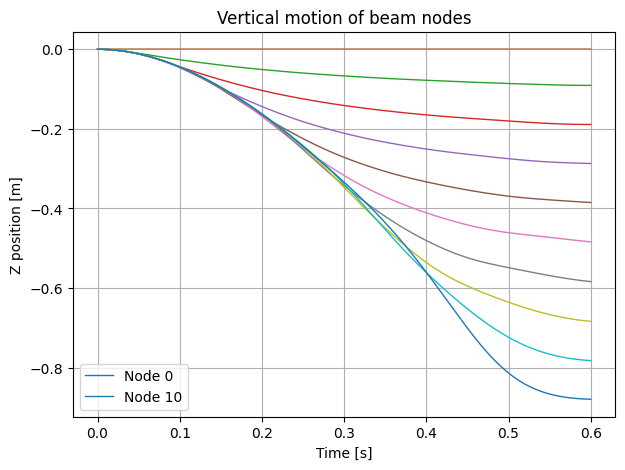

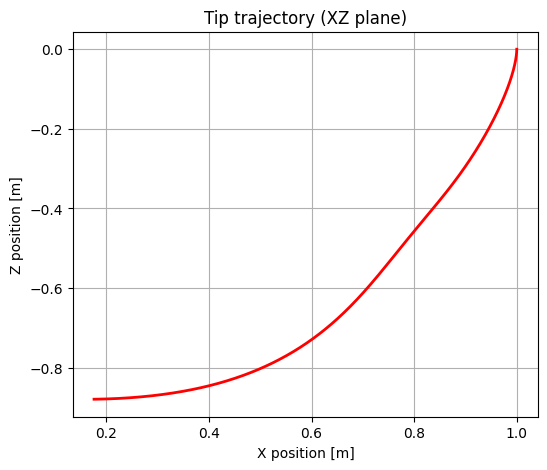

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert trajectory to numpy
q_nodes = q_traj[:, :3*num_nodes]  # (T, 3*num_nodes)
q_traj_np = q_nodes.detach().cpu().numpy().reshape(len(t), num_nodes, 3)
t_np = t.detach().cpu().numpy()

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t_np, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


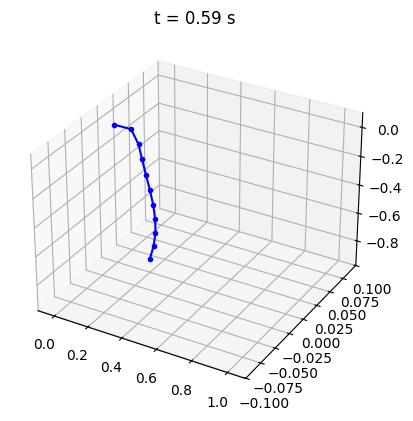

In [18]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 100), interval=50)
ani.save("analytical_3drod.gif", writer="ffmpeg", fps=20)
plt.show()


In [19]:
# plot training loss
plt.figure(figsize=(7,5))
plt.plot(range(1, n_epochs + 1), losses, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

NameError: name 'losses' is not defined

<Figure size 700x500 with 0 Axes>